In [1]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [14]:
import numpy as np
import random
import pandas as pd
from itertools import product
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
# from src.random_search import *
np.random.seed(0)


<!-- #### Data pre-processing for MONK Datasets  -->

In [15]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
# # df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
# #                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# df.set_index("index", inplace=True)
# y = df.iloc[:, 0]  # First column as target
# X = df.iloc[:, 1:]  # All other columns as features
# for i in range(1, X.shape[1]):
#     X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
#         np.std(X.iloc[:, i])
# X.head()


########################################################
### Don't forget to change the path to the data file ###
########################################################

df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
                 names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
#                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
df.set_index("index", inplace=True)
y = df.iloc[:, 0]  # First column as target
X = df.iloc[:, 1:]  # All other columns as features
for i in range(1, X.shape[1]):
    X.iloc[:, i] = X.iloc[:, i].astype('float64')
    X.iloc[:, i] = ((X.iloc[:, i] - np.mean(X.iloc[:, i])) /
                    np.std(X.iloc[:, i]))
X.head()

,1,2,3,4,5,6
index,,,,,,
data_4,1,-1.233337,-1.017912,-1.264063,-0.432844,0.994100
data_7,1,-1.233337,-1.017912,-1.264063,1.395921,-1.005935
data_9,1,-1.233337,-1.017912,-0.050275,-1.347226,-1.005935
data_10,1,-1.233337,-1.017912,-0.050275,-1.347226,0.994100
data_11,1,-1.233337,-1.017912,-0.050275,-0.432844,-1.005935


In [16]:
# ########################################################
# ### Don't forget to change the path to the data file ###
# ########################################################

# test_data = pd.read_csv("../ML_project/data/Monk_2/monks-2.test",
# names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# test_data.set_index("index", inplace=True)
# # test_data.head()
# y_test = test_data.iloc[:, 0]
# X_test = test_data.iloc[:, 1:]
# for i in range(1, X_test.shape[1]):
#     X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])

########################################################
### Don't forget to change the path to the data file ###
########################################################

test_data = pd.read_csv("../ML_project/data/Monk_2/monks-2.test",
                        names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
test_data.set_index("index", inplace=True)
# test_data.head()
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
for i in range(1, X_test.shape[1]):
    X_test.iloc[:, i] = ((X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) /
                         np.std(X_test.iloc[:, i]))

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)

Training Features Shape: (135, 6)
Validation Features Shape: (34, 6)
Training Target Shape: (135,)
Validation Target Shape: (34,)


In [18]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples


class MSE:
    def __init__(self):
        self.dinputs = None
        self.output = None

    def forward(self, y_pred, y_true):
        # Remove the shape condition - always calculate loss
        self.output = np.mean((y_pred - y_true)**2)
        return self.output

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = 2 * (dvalues - y_true) / samples

In [19]:
class NN:
    def __init__(self, l1, l2, input_size, hidden_sizes, output_size,
                 hidden_activations=None, dropout_rates=None,
                 use_batch_norm=None, output_activation=Activation_Sigmoid()):
        self.layers = []
        prev_size = input_size

        # Default activations to ReLU
        if hidden_activations is None:
            hidden_activations = [Activation_ReLU() for _ in hidden_sizes]

        # Default dropout rates to 0
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)

        # Default batch_norm to False for all layers
        if use_batch_norm is None:
            use_batch_norm = [False] * len(hidden_sizes)
        else:
            assert len(use_batch_norm) == len(hidden_sizes), \
                "use_batch_norm must have the same length as hidden_sizes"

        # Create hidden layers
        for size, activation, rate, bn_flag in zip(hidden_sizes, hidden_activations,
                                                   dropout_rates, use_batch_norm):
            # Add dense layer
            self.layers.append(Layer_Dense(prev_size, size, l1=l1, l2=l2))

            # Add batch normalization if specified
            if bn_flag:
                self.layers.append(BatchNormalization())

            # Add activation
            self.layers.append(activation())

            # Add dropout if rate > 0
            if rate > 0:
                self.layers.append(Dropout(rate))

            prev_size = size

        # Output layer
        self.layers.append(Layer_Dense(prev_size, output_size))
        # self.layers.append(output_activation)

    def forward(self, inputs, training=True):
        for layer in self.layers:
            # Pass training flag to relevant layers
            if isinstance(layer, (Dropout, BatchNormalization)):
                layer.forward(inputs, training=training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs
        return self.output

In [20]:
def accuracy(target, output):
    predictions = np.round(output.squeeze())
    return np.mean(predictions == target.squeeze()) * 100

In [21]:
def train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation):
    # Initialize components
    model = NN(
        l1=l1,
        l2=l2,
        input_size=6,
        hidden_sizes=[10],
        output_size=2,
        hidden_activations=[activation],
        dropout_rates=[dropout_rate]
    )
    
    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
    optimizer = Optimizer_Adam(learning_rate=learning_rate)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        batch_losses = []
        batch_accuracies = []
        
        for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
            # Forward pass through model
            model.forward(X_batch, training=True)
            
            # Calculate loss through separate loss activation
            loss = loss_activation.forward(model.output, y_batch)
            # print(y_batch.shape)
            # Calculate accuracy
            predictions = np.argmax(loss_activation.output, axis=1)
            accuracy = np.mean(predictions == y_batch)
            
            # Backward pass
            loss_activation.backward(loss_activation.output, y_batch)
            dvalues = loss_activation.dinputs
            
            # Propagate gradients through model layers in reverse
            for layer in reversed(model.layers):
                layer.backward(dvalues)
                dvalues = layer.dinputs
                
                # # Apply L1/L2 regularization to dense layers
                # if isinstance(layer, Layer_Dense):
                #     if layer.l1 > 0:
                #         layer.dweights += layer.l1 * np.sign(layer.weights)
                #     if layer.l2 > 0:
                #         layer.dweights += 2 * layer.l2 * layer.weights
            
            # Update parameters
            optimizer.pre_update_params()
            for layer in model.layers:
                if isinstance(layer, Layer_Dense):
                    optimizer.update_params(layer)
            optimizer.post_update_params()
            
            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

        # Epoch metrics
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation pass
        model.forward(X_val, training=False)
        val_loss = loss_activation.forward(model.output, y_val)
        val_predictions = np.argmax(loss_activation.output, axis=1)
        val_accuracy = np.mean(val_predictions == y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return model, val_accuracies[-1]

In [22]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            model, val_accuracy = train_and_evaluate(
                learning_rate=hyperparams['learning_rate'],
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                dropout_rate=hyperparams['dropout_rate'],
                batch_size=hyperparams['batch_size'],
                n_epochs=hyperparams['n_epochs'],
                activation=hyperparams['activation']
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")
    
    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)
        
        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=0, 
            arr=predictions
        )
        return final_predictions


In [136]:
## This is grid search. had to comment it.

# hyperparameter_grid = {
#     'learning_rate': [0.001],
#     'l1': [0.0, 1e-5],
#     'l2': [0.0, 1e-4],
#     'dropout_rate': [0.1, 0.5],
#     'batch_size': [4],
#     'n_epochs': [100, 200],
#     'activation': [Activation_Sigmoid, Activation_Leaky_ReLU]
# }

In [23]:
# Random search for finding the best hyperparameters
def random_search(param_distributions, n_iters):
    best_hyperparams = None
    best_performance = -np.inf
    
    for _ in range(n_iters):
        # Let's have sample hyperparameters from distributions
        params = {
            'learning_rate': random.choice(param_distributions['learning_rate']),
            'l1': random.choice(param_distributions['l1']),
            'l2': random.choice(param_distributions['l2']),
            'dropout_rate': random.choice(param_distributions['dropout_rate']),
            'batch_size': random.choice(param_distributions['batch_size']),
            'n_epochs': random.choice(param_distributions['n_epochs']),
            'activation': random.choice(param_distributions['activation']),
        }
        # We train and evaluate the model
        _, val_accuracy = train_and_evaluate(**params)

        # Update the hyperparamters if the current model is doing great
        if val_accuracy > best_performance:
            best_performance = val_accuracy
            best_hyperparams = params
    return best_hyperparams, best_performance

In [24]:
# Define the hyperparameter distributions for random search
# param_distributions = {
#     'learning_rate': [0.0001, 0.001, 0.01, 0.1],
#     'l1': [0.0, 1e-5, 1e-4],
#     'l2': [0.0, 1e-5, 1e-4],
#     'dropout_rate': [0.0, 0.1, 0.2, 0.5],
#     'batch_size': [2, 4, 8, 16],
#     'n_epochs': [50, 100, 150, 200],
#     'activation': [Activation_Sigmoid, Activation_Leaky_ReLU, Activation_ReLU]
# }

# Define the hyperparameter distributions for random search
param_distributions = {
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],  # Logarithmic scale
    'l1': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],  # Wider range
    'l2': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],  # Wider range
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # Wider range
    'batch_size': [2, 4, 8, 16, 32],  # Wider range
    'n_epochs': [50, 100, 150, 200, 300],  # Wider range
    'activation': [Activation_Sigmoid, Activation_Leaky_ReLU, Activation_ReLU]
}

# We then run random search algorithm
best_hyperparams, best_performance = random_search(
    param_distributions, n_iters=20)  # adjust n_iters as needed

print(best_hyperparams)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_23892\899763877.py:18: RuntimeWarning: divide by zero encountered in log
  negative_log_likelihoods = np.log(correct_confidence)


{'learning_rate': 0.01, 'l1': 0.0001, 'l2': 1e-05, 'dropout_rate': 0.0, 'batch_size': 2, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>}


In [25]:
# Create and use ensemble with the best parameters from random search
ensemble = EnsembleNN(n_models=2)
ensemble.create_and_train_models(best_hyperparams)

# Make predictions on test set
test_predictions = ensemble.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

Training model 1/2


C:\Users\KIIT\AppData\Local\Temp\ipykernel_23892\899763877.py:18: RuntimeWarning: divide by zero encountered in log
  negative_log_likelihoods = np.log(correct_confidence)


Model 1 validation accuracy: 0.4412
Training model 2/2
Model 2 validation accuracy: 0.4412
Ensemble Test Accuracy: 0.6713


In [140]:
# # Initialize variables to store the best hyperparameters and performance
# best_hyperparams = None
# best_performance = -np.inf  # Assuming we are maximizing validation accuracy

# # Iterate over all combinations of hyperparameters
# for params in product(*hyperparameter_grid.values()):
#     # Unpack the hyperparameters
#     learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = params
#     # Train and evaluate the model
#     val_accuracy = train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation)
    
#     # Update the best hyperparameters if the current model is better
#     if val_accuracy > best_performance:
#         best_performance = val_accuracy
#         best_hyperparams = {
#             'learning_rate': learning_rate,
#             'l1': l1,
#             'l2': l2,
#             'dropout_rate': dropout_rate,
#             'batch_size': batch_size,
#             'n_epochs': n_epochs,
#             'activation': activation
#         }

# # Print the best hyperparameters and performance
# print("Best Hyperparameters:", best_hyperparams)
# print("Best Validation Accuracy:", best_performance)

In [141]:
# final_model_performance = train_and_evaluate(**best_hyperparams)
# print("Final Model Performance:", final_model_performance)

In [142]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = best_hyperparams.values()
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation

(0.1, 0.0001, 1e-05, 0.2, 16, 200, src.activation_functions.Activation_Sigmoid)

In [26]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta_loss=0.0001,
    min_delta_accuracy=0.000
)

In [27]:
model = NN(l1=0.01,
           l2=0.1,
           input_size=6,
           hidden_sizes=[30, 30],
           output_size=1,
           hidden_activations=[Activation_Leaky_ReLU, Activation_Tanh],
           dropout_rates=[0.1, 0.1],
           use_batch_norm=[False, True],
           )

batch_size = 10000
learning_rate = 0.003
n_epochs = 300

In [144]:
# n_epochs = n_epochs

Data shapes:
X_train: (135, 6), y_train: (135,)
Sample prediction: [[0.]]
Initial loss: 0.0
Epoch 0: Train Loss: 1.0709176946636654, Acc: 33.33333333333333 % | Val Loss: 0.5197797274053277, Acc: 41.17647058823529 % 
Epoch 10: Train Loss: 0.47133179338016795, Acc: 60.0 % | Val Loss: 0.6052145861642823, Acc: 44.11764705882353 % 
Epoch 20: Train Loss: 0.412357273275357, Acc: 56.2962962962963 % | Val Loss: 0.45695693320645187, Acc: 44.11764705882353 % 
Epoch 30: Train Loss: 0.3593917928192763, Acc: 63.70370370370371 % | Val Loss: 0.4223974056521493, Acc: 44.11764705882353 % 
Epoch 40: Train Loss: 0.2954601863035549, Acc: 67.4074074074074 % | Val Loss: 0.38555504736416635, Acc: 41.17647058823529 % 
Epoch 50: Train Loss: 0.24184467000460672, Acc: 68.14814814814815 % | Val Loss: 0.41133564328068045, Acc: 44.11764705882353 % 
Epoch 60: Train Loss: 0.2989766358888661, Acc: 60.0 % | Val Loss: 0.3616315183226595, Acc: 41.17647058823529 % 
Epoch 70: Train Loss: 0.2610070859707269, Acc: 68.88888888

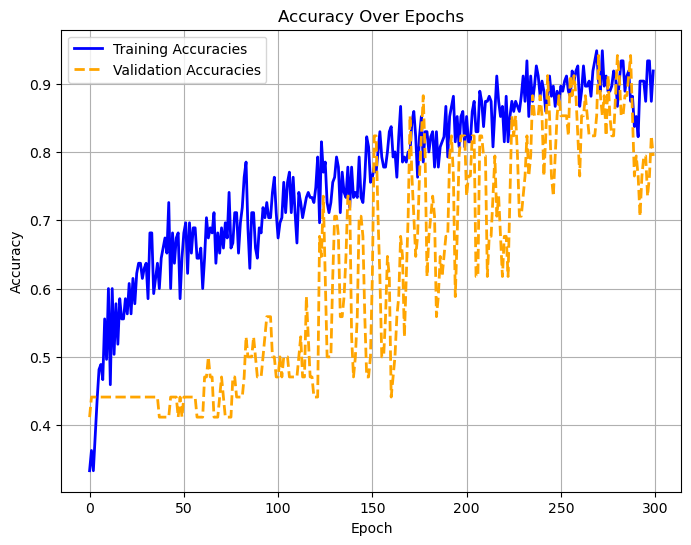

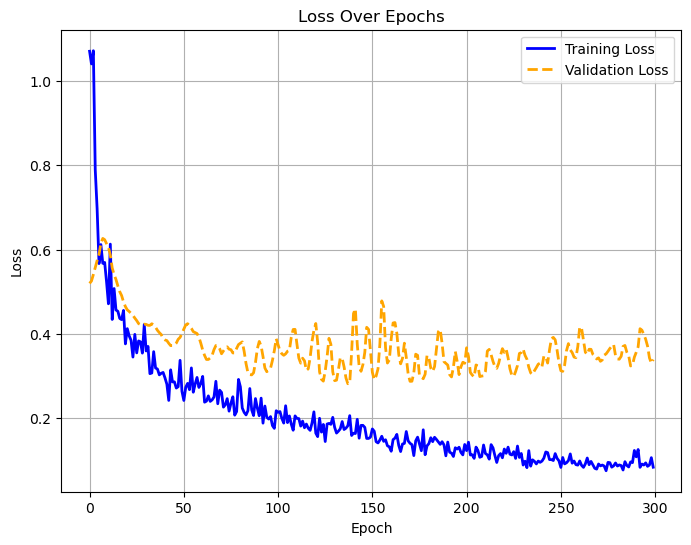

Test Accuracy: 0.8102


In [28]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)
# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Sample prediction: {model.forward(X_train[:1])}")  # Should output ~0.5
print(
    f"Initial loss: {loss_function.forward(model.output, y_train[:1].squeeze())}")
# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Calculate loss
        loss = loss_function.forward(model.output, y_batch)

        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass with shape validation
        loss_function.backward(model.output, y_batch)

        dvalues = loss_function.dinputs

        # Verify gradient shape matches output
        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        # Propagate gradients
        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

            # Ensure numpy arrays
            if isinstance(dvalues, pd.DataFrame):
                dvalues = dvalues.values
            elif isinstance(dvalues, pd.Series):
                dvalues = dvalues.values.reshape(-1, 1)

        # Update parameters
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch metrics
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    # Validation pass
    model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val,
                  training=False)
    # print(model.output)
    val_loss = loss_function.forward(model.output, y_val.values if isinstance(
        y_val, (pd.Series, pd.DataFrame)) else y_val)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Progress reporting
    if epoch % 10 == 0:  # More frequent updates
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss}, Acc: {epoch_acc*100} % | ", end="")
        print(f"Val Loss: {val_loss}, Acc: {val_accuracy*100} % ")

# Final validation with restored weights
model.forward(X_val.values if isinstance(
    X_val, pd.DataFrame) else X_val, training=False)
final_val_loss = loss_function.forward(model.output, y_val.values if isinstance(
    y_val, (pd.Series, pd.DataFrame)) else y_val)
final_val_accuracy = np.mean(
    np.round(model.output.squeeze()) == y_val.squeeze())

# print(len(val_accuracies), len(train_accuracies))
plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies",
                label2="Validation Accuracies", title="Accuracy Over Epochs")
plot_losses(train_losses, val_losses, label1="Training Loss",
            label2="Validation Loss", title="Loss Over Epochs")

model.forward(X_test, training=False)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
# test_accuracies.append(test_accuracy)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [29]:
print(train_losses, val_losses)

[1.0709176946636654, 1.0409105267346288, 1.072192180681033, 0.7898178127576908, 0.6965652351789006, 0.5668107409131778, 0.6120182141410068, 0.5674476186210501, 0.5695514365439742, 0.5236259730239662, 0.47133179338016795, 0.6129990568511368, 0.43415588326397714, 0.5075990790380666, 0.4566544816704081, 0.45362058320776444, 0.4365253512577627, 0.4338523887647522, 0.4556349979198609, 0.3761816354564975, 0.412357273275357, 0.3952541743068756, 0.38459193692441473, 0.34488478688491475, 0.3987189390460343, 0.3548107724784991, 0.38316099764773, 0.381073687328156, 0.3542719517315436, 0.42233333853194316, 0.3593917928192763, 0.3701295470121413, 0.30550940679876704, 0.30702585000444094, 0.3577288750484592, 0.31890449464950177, 0.3165083254882561, 0.3026378142345154, 0.30635196511033097, 0.30836156008976484, 0.2954601863035549, 0.2803926879676753, 0.24194282198343417, 0.31455993605732535, 0.2858227807845992, 0.28611508622816084, 0.27133671507972856, 0.27461329921345623, 0.3371209321357577, 0.263468

In [31]:
# print(np.argmax(test_accuracies))
# print(test_accuracies[np.argmax(test_accuracies)])
# # print(len(test_accuracies))
# # print(best_hyperparams[15])

In [32]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8102


In [147]:
# n_epochs = 350
# batch_size = 1


# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# # early_stopping = EarlyStopping(
# #     patience=20,
# #     min_delta_loss=0.0001,
# #     min_delta_accuracy=0.0001,
# #     restore_best_weights=True
# # )

# # Training loop
# for epoch in range(n_epochs):
#     batch_losses = []
#     batch_accuracies = []
    
#     # Mini-batch training
#     for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#         # Forward pass
#         dense1.forward(X_batch)
#         activation4.forward(dense1.output)
#         dense2.forward(activation4.output)
#         loss = loss_activation.forward(dense2.output, y_batch)
        
#         # Calculate accuracy for this batch
#         predictions = np.argmax(loss_activation.output, axis=1)
#         if len(y_batch.shape) == 2:
#             y_true = np.argmax(y_batch, axis=1)
#         else:
#             y_true = y_batch
#         accuracy = np.mean(predictions == y_true)
        
#         # Backward pass
#         loss_activation.backward(loss_activation.output, y_batch)
#         dense2.backward(loss_activation.dinputs)
#         activation4.backward(dense2.dinputs)
#         dense1.backward(activation4.dinputs)
        
#         # Update weights and biases
#         optimizer.pre_update_params()
#         optimizer.update_params(dense1)
#         optimizer.update_params(dense2)
#         optimizer.post_update_params()
        
#         batch_losses.append(loss)
#         batch_accuracies.append(accuracy)
    
#     # Calculate epoch-level training metrics
#     epoch_loss = np.mean(batch_losses)
#     epoch_accuracy = np.mean(batch_accuracies)
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_accuracy)

#     # Validation pass (entire validation dataset)
#     dense1.forward(X_val)
#     activation4.forward(dense1.output)
#     dense2.forward(activation4.output)
#     val_loss = loss_activation.forward(dense2.output, y_val)
    
#     # Calculate validation accuracy
#     val_predictions = np.argmax(loss_activation.output, axis=1)
#     if len(y_val.shape) == 2:
#         y_val_true = np.argmax(y_val, axis=1)
#     else:
#         y_val_true = y_val
#     val_accuracy = np.mean(val_predictions == y_val_true)
    
#     # Append validation metrics
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)
    
#     # early_stopping.on_epoch_end(
#     #     current_loss=val_loss,
#     #     current_accuracy=val_accuracy,
#     #     model=[dense1, dense2], 
#     #     epoch=epoch
#     # )
#     # if early_stopping.stop_training:
#     #     print(f"Early stopping at epoch {epoch}")
#     #     break
    
#     # Print progress
#     if not epoch % 100:
#         print(f"epoch: {epoch}, "
#               f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
#               f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
#               f"learning_rate: {optimizer.current_learning_rate}")

# plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
# plot_accuracies(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")